## Import Libraries

In [1]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Sequential, Model
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow import keras

#please import any required libraries
import tensorflow as tf
import pathlib
import sys
import os
import cv2

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
# data is in "data" folder, contains 9 classes. Please build an image classification model to classify images.

## Read and Analyse the Data

In [2]:
## Manual Check: 
# Image wrongly found in this folder 3_4th_driver_side_front which belongs to 3_4th_driver_side_rear
# Moved the image to the correct folder.

# Distribution check: 
# 500 images in each folder which is balanced.

## Data Processing - Placing the data in train, test and validation folders

In [9]:
%%time

#please analyse the data and figure if data requires any pre-processing or augmentation.

# Each folder has 500 Images.
        
def load_and_save_imgs(out_folder,folder,angle_fldr):
    if not os.path.exists(out_folder+f"data_split/train/{angle_fldr}/"):
        os.makedirs(out_folder+f"data_split/train/{angle_fldr}/")
    if not os.path.exists(out_folder+f"data_split/val/{angle_fldr}/"):
        os.makedirs(out_folder+f"data_split/val/{angle_fldr}/")
    if not os.path.exists(out_folder+f"data_split/test/{angle_fldr}/"):
        os.makedirs(out_folder+f"data_split/test/{angle_fldr}/")
    
    images = []
    length_dir = len(os.listdir(folder)) #500
    for file in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,file))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            rnd = random.randint(0,length_dir)
            if rnd<400: # 80% data
                cv2.imwrite(out_folder+f"data_split/train/{angle_fldr}/{file}",img)
            elif rnd<450:  #10% data
                cv2.imwrite(out_folder+f"data_split/val/{angle_fldr}/{file}",img)
            elif rnd<500: #10% data
                cv2.imwrite(out_folder+f"data_split/test/{angle_fldr}/{file}",img)
    print(f'{angle_fldr} processing done!!!')
    
###############################################################    

out_folder = "/home/jovyan/Practice/Assignments/"
for ind,angle_fldr in enumerate(tqdm(os.listdir(out_folder+'data/'))):
    folder = out_folder+'data/'+angle_fldr+"/"
    load_and_save_imgs(out_folder,folder,angle_fldr)


 11%|█         | 1/9 [00:27<03:36, 27.12s/it]

3_4th_driver_side_front processing done!!!


 22%|██▏       | 2/9 [00:54<03:10, 27.27s/it]

3_4th_driver_side_rear processing done!!!


 33%|███▎      | 3/9 [01:21<02:42, 27.01s/it]

3_4th_passenger_side_front processing done!!!


 44%|████▍     | 4/9 [01:47<02:14, 26.86s/it]

3_4th_passenger_side_rear processing done!!!


 56%|█████▌    | 5/9 [02:12<01:44, 26.22s/it]

driver_side processing done!!!


 67%|██████▋   | 6/9 [02:38<01:18, 26.17s/it]

front processing done!!!


 78%|███████▊  | 7/9 [03:03<00:51, 25.88s/it]

passenger_side processing done!!!


 89%|████████▉ | 8/9 [03:28<00:25, 25.52s/it]

rear processing done!!!


100%|██████████| 9/9 [03:51<00:00, 25.72s/it]

unknown processing done!!!
CPU times: user 1min 47s, sys: 37.8 s, total: 2min 25s
Wall time: 3min 51s


In [5]:
class_dict = {}
for ind,angle_fldrs in enumerate(os.listdir("/home/jovyan/Practice/Assignments/data/")):
    class_dict[ind] = angle_fldrs
print(class_dict)  

{0: '3_4th_driver_side_front', 1: '3_4th_driver_side_rear', 2: '3_4th_passenger_side_front', 3: '3_4th_passenger_side_rear', 4: 'driver_side', 5: 'front', 6: 'passenger_side', 7: 'rear', 8: 'unknown'}


## Splitting Data

In [6]:
## Split data 80% training, 10% Validation, 10% testing

# Total Images = 9*500 = 4500

# Data is randomly split in the above cells.

out_folder = "/home/jovyan/Practice/Assignments/"

cnt_train,cnt_val,cnt_test = 0,0,0
for ind,angle_fldr in enumerate(os.listdir(out_folder+'data/')):
    for file in os.listdir(out_folder+f"data_split/train/{angle_fldr}/"):
        cnt_train+=1
    for file in os.listdir(out_folder+f"data_split/val/{angle_fldr}/"):
        cnt_val+=1
    for file in os.listdir(out_folder+f"data_split/test/{angle_fldr}/"):
        cnt_test+=1

print(f'Train: {cnt_train}, Val: {cnt_val}, Test: {cnt_test}')

Train: 3612, Val: 466, Test: 411


## Define Generator

In [ ]:
## add pre-processing, augmentation
#datagen = ImageDataGenerator(
#        ##add Code Here
#    )
#
#train_generator = datagen.flow_from_directory(
#   ##add Code Here
#)
#
#validation_generator = datagen.flow_from_directory(
#    ##add Code Here
#)

In [20]:
# add pre-processing, augmentation
train_datagen = ImageDataGenerator(
                rescale=1./255,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

height, width =150,150 # Tried with different shapes
batch_size = 64 # Tried with batch sizes 32 and 64
train_generator = train_datagen.flow_from_directory(
   '/home/jovyan/Practice/Assignments/data_split/train/',
    target_size=(height, width),
    batch_size=batch_size,
    shuffle=True,
    class_mode='sparse',
    seed=43
)

validation_generator = val_datagen.flow_from_directory(
   '/home/jovyan/Practice/Assignments/data_split/val/',
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='sparse',
    seed=43
)

Found 3612 images belonging to 9 classes.
Found 466 images belonging to 9 classes.


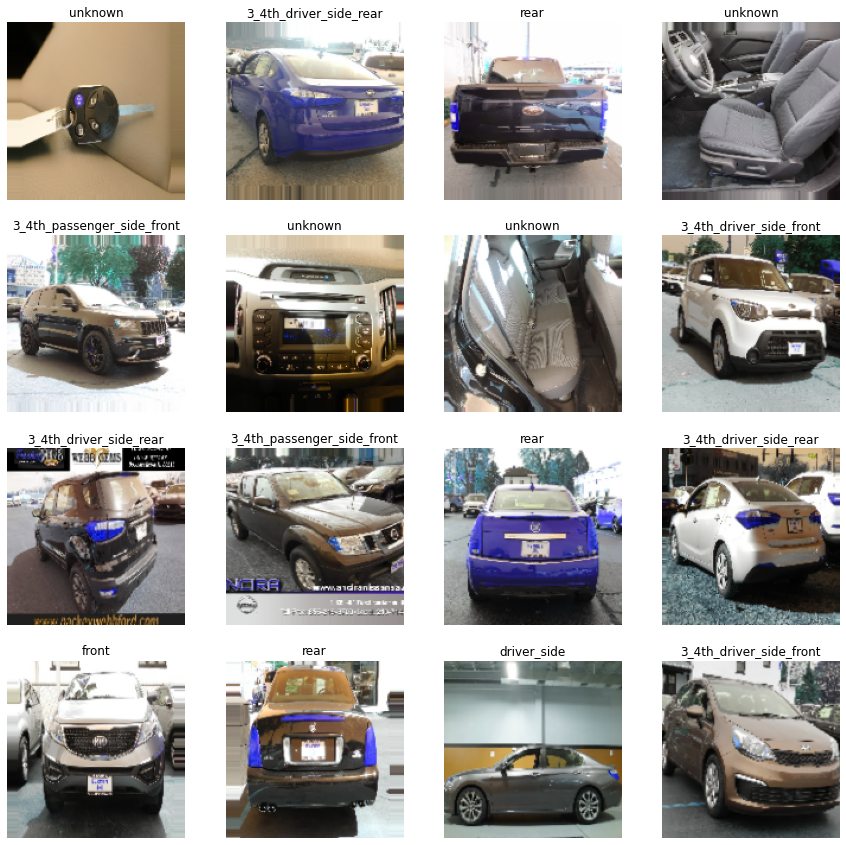

In [100]:
plt.figure(figsize=(15, 15))

img_batch = train_generator.next()
for i in range(0,16):
    image = img_batch[0][i]
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(class_dict[img_batch[1][i]])
    plt.axis("off")

## Train Data Distribution

In [43]:
counts = np.bincount(train_generator.labels) 
for i in range(9):
    print(f'{class_dict[i]} -> {counts[i]}')

3_4th_driver_side_front -> 410
3_4th_driver_side_rear -> 398
3_4th_passenger_side_front -> 409
3_4th_passenger_side_rear -> 403
driver_side -> 406
front -> 388
passenger_side -> 400
rear -> 401
unknown -> 397


## Define Model

In [21]:
# input image dimensions
#img_rows, img_cols = 256, 256

if tf.keras.backend.image_data_format() == 'channels_first':
    input_shape = (3, height, width)
else:
    input_shape = (height, width, 3)

print(input_shape)

(150, 150, 3)


In [22]:
basemodel = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
basemodel.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [23]:
for i, layer in enumerate(basemodel.layers):
    print(i, layer.name)

0 input_2
1 conv2d_94
2 batch_normalization_94
3 activation_94
4 conv2d_95
5 batch_normalization_95
6 activation_95
7 conv2d_96
8 batch_normalization_96
9 activation_96
10 max_pooling2d_4
11 conv2d_97
12 batch_normalization_97
13 activation_97
14 conv2d_98
15 batch_normalization_98
16 activation_98
17 max_pooling2d_5
18 conv2d_102
19 batch_normalization_102
20 activation_102
21 conv2d_100
22 conv2d_103
23 batch_normalization_100
24 batch_normalization_103
25 activation_100
26 activation_103
27 average_pooling2d_9
28 conv2d_99
29 conv2d_101
30 conv2d_104
31 conv2d_105
32 batch_normalization_99
33 batch_normalization_101
34 batch_normalization_104
35 batch_normalization_105
36 activation_99
37 activation_101
38 activation_104
39 activation_105
40 mixed0
41 conv2d_109
42 batch_normalization_109
43 activation_109
44 conv2d_107
45 conv2d_110
46 batch_normalization_107
47 batch_normalization_110
48 activation_107
49 activation_110
50 average_pooling2d_10
51 conv2d_106
52 conv2d_108
53 conv2d

In [24]:
end_shape = basemodel.layers[-1].output_shape
print(end_shape)
print(len(basemodel.layers))

(None, 3, 3, 2048)
311


In [25]:
## Let's take a look to see how many layers are in the base model
#print("Number of layers in the base model: ", len(base_model.layers))
#
## Fine-tune from this layer onwards
#fine_tune_at = 100
#
## Freeze all the layers before the `fine_tune_at` layer
#for layer in base_model.layers[:fine_tune_at]:
#    layer.trainable = False

In [26]:
# add Fully connected last layers( as many as you like to improve the performance), 
#try-out drop-out in Fully connected layers if you think it is necessary
def add_last_layer(model, n_classes, fc_layer_size):
    
    ## Add your code here
    top_model = Sequential([
      layers.Flatten(input_shape=(end_shape[1], end_shape[2], end_shape[3])),
      layers.Dense(fc_layer_size, activation='relu'),
      layers.Dropout(0.3),
      layers.Dense(n_classes)
    ])
    
    model.add(top_model)
    
    return model

n_classes = 9
fc_layer_size = 64
#model = InceptionV3(weights='imagenet', include_top=False)
model=Sequential()
model.add(basemodel)
model = add_last_layer(model, n_classes, fc_layer_size)


## Compiling Model

In [ ]:
# the first 249 layers and unfreeze the rest:
#for layer in model.layers[:249]:
#    layer.trainable = False
#for layer in model.layers[249:]:
#    layer.trainable = True


# Tried freezing some layers and the metric performance was very bad. Need to experiment.

In [27]:
#Add callbacks like early stopping, cyclical or variable learning rate or anyting you feel necessary
#opt = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=5e-04)
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=5e-04)
##add Code Here

# Stop training when a monitored quantity has stopped improving.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
#Reduce learning rate when a metric has stopped improving.
#reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.22, patience = 1, verbose = 1, min_delta = 0.0001)

##add model compile code here
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Training

In [28]:
##Freeze some layers first and then train the unfrozen layers it. (experiment with number of layers to freeze for best metrics)
##Next train all the layers
#history_tl = model.fit_generator(
#        ##add Code Here)

In [29]:
%%time

epochs = 15
history = model.fit_generator(
        train_generator,
        steps_per_epoch=50,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=10,
        verbose=2
        )

/opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
50/50 - 179s - loss: 1.5072 - accuracy: 0.4535 - val_loss: 58.6901 - val_accuracy: 0.1159
Epoch 2/15
50/50 - 165s - loss: 0.7829 - accuracy: 0.6255
Epoch 3/15
50/50 - 170s - loss: 0.7248 - accuracy: 0.6552
Epoch 4/15
50/50 - 167s - loss: 0.6244 - accuracy: 0.6707
Epoch 5/15
50/50 - 169s - loss: 0.6264 - accuracy: 0.6792
Epoch 6/15
50/50 - 169s - loss: 0.7064 - accuracy: 0.6634
Epoch 7/15
50/50 - 170s - loss: 0.6286 - accuracy: 0.6770
Epoch 8/15
50/50 - 176s - loss: 0.5752 - accuracy: 0.6809
Epoch 9/15
50/50 - 172s - loss: 0.5104 - accuracy: 0.7118
Epoch 10/15
50/50 - 178s - loss: 0.4884 - accuracy: 0.7241
Epoch 11/15
50/50 - 177s - loss: 0.4572 - accuracy: 0.7447
Epoch 12/15
50/50 - 193s - loss: 0.4629 - accuracy: 0.7443
Epoch 13/15
50/50 - 208s - loss: 0.4540 - accuracy: 0.7424
Epoch 14/15
50/50 - 210s - loss: 0.4702 - accuracy: 0.7405
Epoch 15/15
50/50 - 212s - loss: 0.4622 - accuracy: 0.7478
CPU times: user 6h 52min 30s, sys: 28min 33s, total: 7h 21min 3s
Wall time: 45min

In [30]:
#history = history_tl
#acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']
#
#loss = history.history['loss']
#val_loss = history.history['val_loss']
#
##epochs = 10
#epochs_range = range(epochs)
#
#plt.figure(figsize=(10, 10))
#plt.subplot(1, 2, 1)
#plt.plot(epochs_range, acc, label='Training Accuracy')
#plt.plot(epochs_range, val_acc, label='Validation Accuracy')
#plt.legend(loc='lower right')
#plt.title('Training and Validation Accuracy')
#
#plt.subplot(1, 2, 2)
#plt.plot(epochs_range, loss, label='Training Loss')
#plt.plot(epochs_range, val_loss, label='Validation Loss')
#plt.legend(loc='upper right')
#plt.title('Training and Validation Loss')
#plt.show()

## Testing

In [65]:
##add Code Here to preprocess image before testing
# Pick the best model weights for testing and test it on few images
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
   '/home/jovyan/Practice/Assignments/data_split/test/',
    target_size=(height, width),
    batch_size=1,
    class_mode='sparse',
    shuffle=False,
)

filenames = test_generator.filenames
nb_samples = len(filenames)
predict = model.predict_generator(test_generator,steps = nb_samples)

Found 411 images belonging to 9 classes.


/opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [66]:
print("Test-Loss: ",model.evaluate_generator(test_generator)[0])
print("Test-Score: ",model.evaluate_generator(test_generator)[1])

/opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test-Loss:  0.458858847618103
Test-Score:  0.7323601245880127


In [70]:
cnt=0
for i in range(411):
    score = tf.nn.softmax(predict[i])
    if np.argmax(score)==test_generator.labels[i]:
        cnt+=1
print(cnt,cnt/len(predict))


301 0.732360097323601


In [32]:
class_dict

{0: '3_4th_driver_side_front',
 1: '3_4th_driver_side_rear',
 2: '3_4th_passenger_side_front',
 3: '3_4th_passenger_side_rear',
 4: 'driver_side',
 5: 'front',
 6: 'passenger_side',
 7: 'rear',
 8: 'unknown'}

In [71]:
for i in range(10):
    temp = random.randint(0,nb_samples) # Randomly picking samples between 0 & len(test_data)
    score = tf.nn.softmax(predict[temp])
    print(f" Original Class: {test_generator.labels[temp]} -> {class_dict[test_generator.labels[temp]]}")
    print(f" predicted class:{np.argmax(score)} -> {class_dict[np.argmax(score)]}-> {100 * np.max(score)} %.")
    print('*'*100)

 Original Class: 7 -> rear
 predicted class:7 -> rear-> 98.05906414985657 %.
****************************************************************************************************
 Original Class: 1 -> 3_4th_driver_side_rear
 predicted class:1 -> 3_4th_driver_side_rear-> 61.12813353538513 %.
****************************************************************************************************
 Original Class: 7 -> rear
 predicted class:7 -> rear-> 100.0 %.
****************************************************************************************************
 Original Class: 4 -> driver_side
 predicted class:4 -> driver_side-> 53.406333923339844 %.
****************************************************************************************************
 Original Class: 6 -> passenger_side
 predicted class:4 -> driver_side-> 52.428245544433594 %.
****************************************************************************************************
 Original Class: 3 -> 3_4th_passenger_side_rear
 pred

## Improving Model

In [ ]:
#Please add your thoughts on way to improve the model.

# Given the time constraints - one day, I couldn't experiment much with tuning the parameters as it is taking time.

# We can try to tune different parameters such as #layers,batch_size,learning_rate, hidden units
# We are not seeing any overfitting, so we can increase the complexity of the model.
# We can run longer epochs with early stopping, reduce learning rate dynamically for each epoch
# We can experiment with #layers to freeze.
# We can experiment with different augmentation techniques.
# We can check the data manually and figure out if there are any misplaced classes in any of the folders.


